# Transformer for Parity Problem
## Compatible TF Version: 2.4.1

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [21]:
vocab_size = 2  # Only consider the top 20k words
maxlen = 20  # Only consider the first 200 words of each movie review


In [22]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [23]:
model.compile("adam", "binary_crossentropy", metrics=["binary_accuracy"])

In [24]:
from keras.utils import plot_model

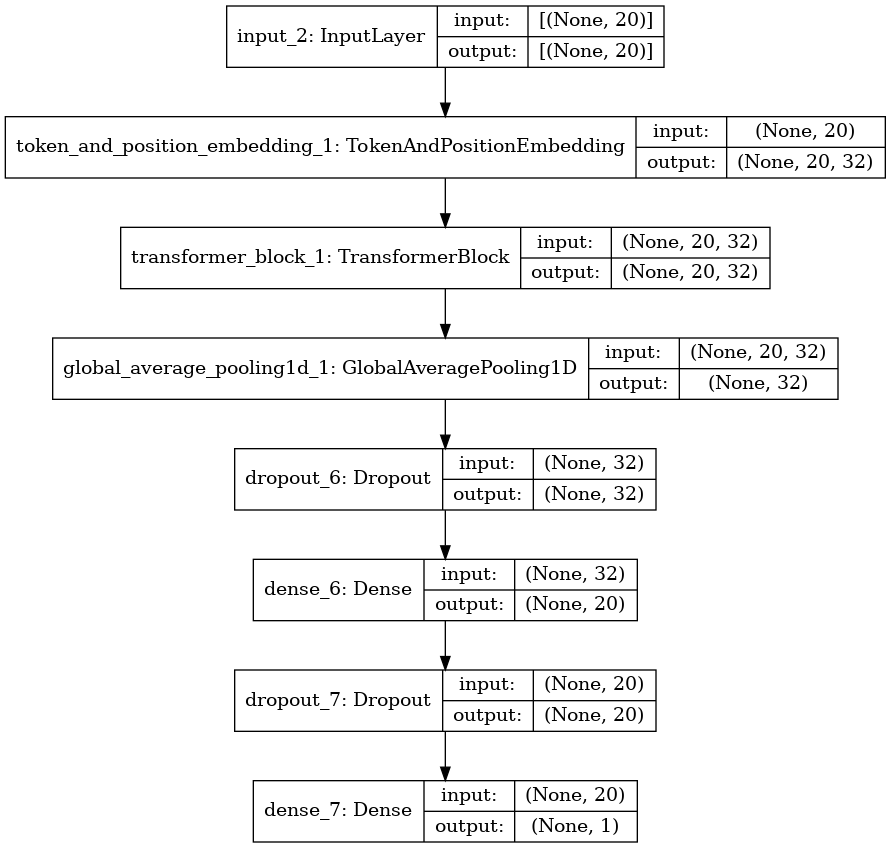

In [25]:
plot_model(model,to_file='transformer.png',show_shapes=True,expand_nested=True)

In [26]:
import numpy as np

In [27]:
# General random vector of binary values - just reshape below
n = 1000
x_train = np.int32(np.round(np.random.uniform(0,1,[maxlen*n])).reshape([n,maxlen]))
x_val = np.int32(np.round(np.random.uniform(0,1,[maxlen*n])).reshape([n,maxlen]))

In [28]:
x_train

array([[1, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 0]], dtype=int32)

In [29]:
y_train = np.apply_along_axis(lambda x: np.sum(x)%2, 1, x_train)
y_val = np.apply_along_axis(lambda x: np.sum(x)%2, 1, x_val)

In [30]:
history = model.fit(x_train, y_train, batch_size=128,
                    epochs=500,
                    validation_data=(x_val, y_val),
                    verbose=0)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

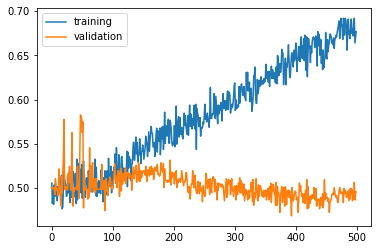

In [32]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()